In [1]:
# ----------------------------
# Imports
# ----------------------------
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import os

# ----------------------------
# 1. Dataset & Dataloader
# ----------------------------
class CXRDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # Encode sex column to numeric: M -> 1, F -> 0
        self.df['sex'] = self.df['sex'].map({'M': 1, 'F': 0}).astype(float)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            image = self.transform(image)

        # metadata = [age, sex]
        metadata = torch.tensor([row['age'], row['sex']], dtype=torch.float32)

        # classification label
        label = torch.tensor(row['label'], dtype=torch.long)

        return image, metadata, label


# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Adjust paths to your data
csv_file = "../data/sample_metadata.csv"
img_dir = "../data/sample_images"

# Dataset + DataLoader
dataset = CXRDataset(csv_file, img_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# ----------------------------
# 2. Image Encoder
# ----------------------------
class ImageEncoder(nn.Module):
    def __init__(self, output_dim=128):
        super(ImageEncoder, self).__init__()
        backbone = models.resnet18(pretrained=True)
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()  # remove classifier
        self.backbone = backbone
        self.fc = nn.Linear(in_features, output_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

# ----------------------------
# 3. Metadata Encoder
# ----------------------------
class MetadataEncoder(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=128):
        super(MetadataEncoder, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.mlp(x)

# ----------------------------
# 4. Test Encoders
# ----------------------------
# Grab a batch
images, metadata, labels = next(iter(dataloader))

# Convert grayscale images (1 channel) to RGB (3 channels) for ResNet
images_rgb = images.repeat(1, 3, 1, 1)

# Initialize encoders
img_encoder = ImageEncoder(output_dim=128)
meta_encoder = MetadataEncoder(input_dim=2, hidden_dim=64, output_dim=128)

# Forward pass
with torch.no_grad():
    img_features = img_encoder(images_rgb)    # [batch, 128]
    meta_features = meta_encoder(metadata)    # [batch, 128]

print("Image encoded shape:", img_features.shape)
print("Metadata encoded shape:", meta_features.shape)


FileNotFoundError: [Errno 2] No such file or directory: '../data/sample_metadata.csv'

In [43]:
import os
import pandas as pd
from PIL import Image
import numpy as np

# Paths
data_dir = "../data"
img_dir = os.path.join(data_dir, "sample_images")
os.makedirs(img_dir, exist_ok=True)

# Make 5 dummy grayscale images
for i in range(5):
    arr = (np.random.rand(224, 224) * 255).astype(np.uint8)
    Image.fromarray(arr).save(os.path.join(img_dir, f"img_{i}.png"))

# Create sample metadata.csv
df = pd.DataFrame({
    "filename": [f"img_{i}.png" for i in range(5)],
    "age": [25, 40, 60, 35, 50],
    "gender": [0, 1, 0, 1, 0],  # 0=male, 1=female
    "label": [0, 1, 0, 1, 0]    # dummy disease labels
})
df.to_csv(os.path.join(data_dir, "sample_metadata.csv"), index=False)

print("✅ Dummy dataset created at:", data_dir)


✅ Dummy dataset created at: ../data


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# ------------------------
# Image Encoder
# ------------------------
class ImageEncoder(nn.Module):
    def __init__(self, output_dim=128):
        super(ImageEncoder, self).__init__()
        base_model = models.resnet18(pretrained=True)
        in_features = base_model.fc.in_features
        base_model.fc = nn.Identity()  # remove classification head
        self.base = base_model
        self.fc = nn.Linear(in_features, output_dim)

    def forward(self, x):
        x = self.base(x)
        return self.fc(x)

# ------------------------
# Metadata Encoder
# ------------------------
class MetadataEncoder(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=128):
        super(MetadataEncoder, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.mlp(x)

# ------------------------
# Fusion Module
# ------------------------
class FusionModule(nn.Module):
    def __init__(self, img_dim=128, meta_dim=128, hidden_dim=128, out_dim=2, strategy="concat"):
        super(FusionModule, self).__init__()
        self.strategy = strategy

        if strategy == "concat":
            self.fc = nn.Sequential(
                nn.Linear(img_dim + meta_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, out_dim)
            )

        elif strategy == "attention":
            self.query = nn.Linear(img_dim, hidden_dim)
            self.key = nn.Linear(meta_dim, hidden_dim)
            self.value = nn.Linear(meta_dim, hidden_dim)
            self.fc = nn.Linear(hidden_dim, out_dim)

        elif strategy == "gating":
            self.gate = nn.Sequential(
                nn.Linear(meta_dim, img_dim),
                nn.Sigmoid()
            )
            self.fc = nn.Sequential(
                nn.Linear(img_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, out_dim)
            )
        else:
            raise ValueError("Invalid fusion strategy.")

    def forward(self, img_features, meta_features):
        if self.strategy == "concat":
            x = torch.cat([img_features, meta_features], dim=1)
            return self.fc(x)

        elif self.strategy == "attention":
            Q = self.query(img_features)
            K = self.key(meta_features)
            V = self.value(meta_features)
            attn_weights = torch.softmax(
                torch.bmm(Q.unsqueeze(1), K.unsqueeze(2)) / (K.size(-1) ** 0.5),
                dim=-1
            )
            attn_output = (attn_weights.squeeze(-1) * V)
            return self.fc(attn_output)

        elif self.strategy == "gating":
            gate_values = self.gate(meta_features)
            gated_img = img_features * gate_values
            return self.fc(gated_img)

# ------------------------
# Full Multimodal Model
# ------------------------
class MultimodalModel(nn.Module):
    def __init__(self, fusion_strategy="concat", num_classes=2):
        super(MultimodalModel, self).__init__()
        self.img_encoder = ImageEncoder(output_dim=128)
        self.meta_encoder = MetadataEncoder(input_dim=2, hidden_dim=64, output_dim=128)
        self.fusion = FusionModule(img_dim=128, meta_dim=128, hidden_dim=128,
                                   out_dim=num_classes, strategy=fusion_strategy)

    def forward(self, images, metadata):
        img_features = self.img_encoder(images)
        meta_features = self.meta_encoder(metadata)
        return self.fusion(img_features, meta_features)


In [46]:
# Dummy batch
images, metadata, labels = next(iter(dataloader))  # from earlier
images_rgb = images.repeat(1, 3, 1, 1)  # convert to RGB

# Model
model = MultimodalModel(fusion_strategy="concat", num_classes=2)

# Forward pass
out = model(images_rgb, metadata)
print("Final model output shape:", out.shape)  # [B, 2]


Final model output shape: torch.Size([4, 2])


In [48]:
# Model (fusion_strategy: "concat", "attention", or "gating")
model = MultimodalModel(fusion_strategy="concat", num_classes=2)
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [49]:
num_epochs = 5  # change as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, metadata, labels in dataloader:
        # Move to device
        images = images.repeat(1, 3, 1, 1).to(device)  # convert to RGB
        metadata = metadata.to(device)
        labels = labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {epoch_loss:.4f}  Accuracy: {epoch_acc:.4f}")


Epoch [1/5]  Loss: 0.5589  Accuracy: 0.6000
Epoch [2/5]  Loss: 1.9382  Accuracy: 0.6000
Epoch [3/5]  Loss: 0.2288  Accuracy: 0.8000
Epoch [4/5]  Loss: 1.1559  Accuracy: 0.6000
Epoch [5/5]  Loss: 0.5177  Accuracy: 0.6000


In [50]:
from torch.utils.data import random_split

# Suppose dataset has 100 samples; adjust as needed
dataset_size = len(dataset)
val_size = int(0.2 * dataset_size)  # 20% for validation
train_size = dataset_size - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [61]:
import copy

num_epochs = 20
patience = 3  # stop if validation loss doesn't improve for 3 epochs
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    # ------------------ Training ------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, metadata, labels in train_loader:
        images = images.repeat(1,3,1,1).to(device)
        metadata = metadata.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # ------------------ Validation ------------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, metadata, labels in val_loader:
            images = images.repeat(1,3,1,1).to(device)
            metadata = metadata.to(device)
            labels = labels.to(device)

            outputs = model(images, metadata)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    # ------------------ Early Stopping ------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model weights
model.load_state_dict(best_model_wts)


Epoch [1/20] Train Loss: 0.0001 Train Acc: 1.0000 Val Loss: 0.0039 Val Acc: 1.0000
Epoch [2/20] Train Loss: 0.0001 Train Acc: 1.0000 Val Loss: 0.0036 Val Acc: 1.0000
Epoch [3/20] Train Loss: 0.0001 Train Acc: 1.0000 Val Loss: 0.0033 Val Acc: 1.0000
Epoch [4/20] Train Loss: 0.0001 Train Acc: 1.0000 Val Loss: 0.0031 Val Acc: 1.0000
Epoch [5/20] Train Loss: 0.0001 Train Acc: 1.0000 Val Loss: 0.0029 Val Acc: 1.0000
Epoch [6/20] Train Loss: 0.0001 Train Acc: 1.0000 Val Loss: 0.0027 Val Acc: 1.0000
Epoch [7/20] Train Loss: 0.0001 Train Acc: 1.0000 Val Loss: 0.0026 Val Acc: 1.0000
Epoch [8/20] Train Loss: 0.0001 Train Acc: 1.0000 Val Loss: 0.0024 Val Acc: 1.0000
Epoch [9/20] Train Loss: 0.0001 Train Acc: 1.0000 Val Loss: 0.0023 Val Acc: 1.0000
Epoch [10/20] Train Loss: 0.0001 Train Acc: 1.0000 Val Loss: 0.0022 Val Acc: 1.0000
Epoch [11/20] Train Loss: 0.0001 Train Acc: 1.0000 Val Loss: 0.0021 Val Acc: 1.0000
Epoch [12/20] Train Loss: 0.0001 Train Acc: 1.0000 Val Loss: 0.0021 Val Acc: 1.0000
E

<All keys matched successfully>

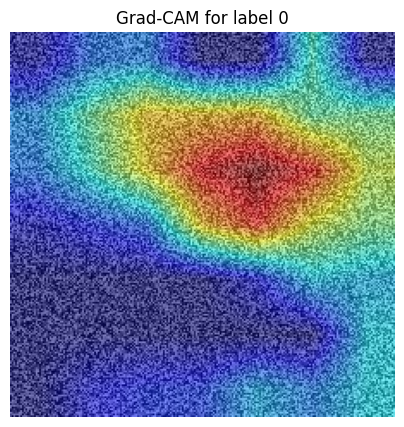

In [52]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np

model.eval()

# Pick a batch
images, metadata, labels = next(iter(val_loader))
images_rgb = images.repeat(1,3,1,1).to(device)
metadata = metadata.to(device)

# Choose the last layer of image encoder
target_layer = model.img_encoder.base.layer4[-1]

# Initialize Grad-CAM (no use_cuda argument)
cam = GradCAM(model=model.img_encoder, target_layers=[target_layer])

# Compute CAM for the first sample
grayscale_cam = cam(input_tensor=images_rgb, targets=[ClassifierOutputTarget(labels[0].item())])
grayscale_cam = grayscale_cam[0, :]
rgb_img = images_rgb[0].cpu().permute(1,2,0).numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())  # normalize for visualization
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(5,5))
plt.imshow(cam_image)
plt.title(f"Grad-CAM for label {labels[0].item()}")
plt.axis('off')
plt.show()



In [53]:
import torch.nn as nn
import torch.nn.functional as F

# Wrapper model for SHAP
class MetaWrapper(nn.Module):
    def __init__(self, meta_encoder, num_classes=2):
        super(MetaWrapper, self).__init__()
        self.meta_encoder = meta_encoder
        self.classifier = nn.Linear(128, num_classes)  # same output_dim as meta_encoder
    
    def forward(self, x):
        x = self.meta_encoder(x)
        x = self.classifier(x)
        return F.softmax(x, dim=1)  # probabilities


In [54]:
# Put encoder in eval mode
meta_encoder.eval()

# Wrap it with classifier head
meta_model = MetaWrapper(meta_encoder, num_classes=2).to(device)
meta_model.eval()


MetaWrapper(
  (meta_encoder): MetadataEncoder(
    (mlp): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
    )
  )
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)

d:\Anaconda\envs\cxr-multimodal\lib\site-packages\shap\plots\_beeswarm.py:733: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim((slow, shigh))
d:\Anaconda\envs\cxr-multimodal\lib\site-packages\shap\plots\_beeswarm.py:753: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim((slow, shigh))


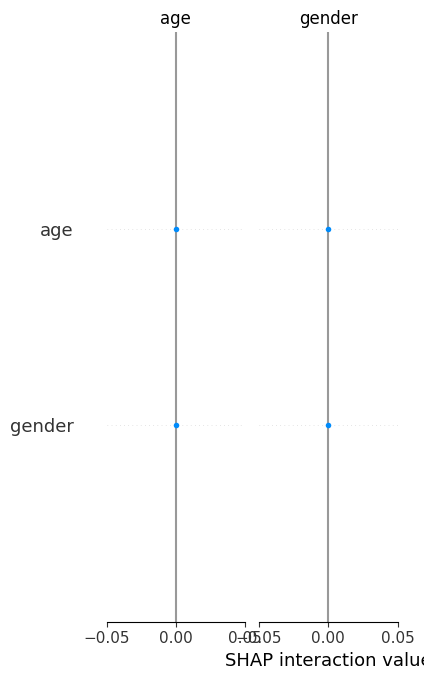

In [56]:
import shap

# Make sure model is in eval mode
meta_model.eval()

# 1. Pick sample batch (Tensor, stays on device)
metadata_sample = metadata[:10].to(device)

# 2. Use DeepExplainer for PyTorch models
explainer = shap.DeepExplainer(meta_model, metadata_sample)

# 3. Compute SHAP values
shap_values = explainer.shap_values(metadata_sample)

# 4. Plot summary
shap.summary_plot(
    shap_values,
    features=metadata_sample.cpu().numpy(),
    feature_names=['age', 'gender']
)


d:\Anaconda\envs\cxr-multimodal\lib\site-packages\shap\plots\_beeswarm.py:733: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim((slow, shigh))
d:\Anaconda\envs\cxr-multimodal\lib\site-packages\shap\plots\_beeswarm.py:753: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim((slow, shigh))


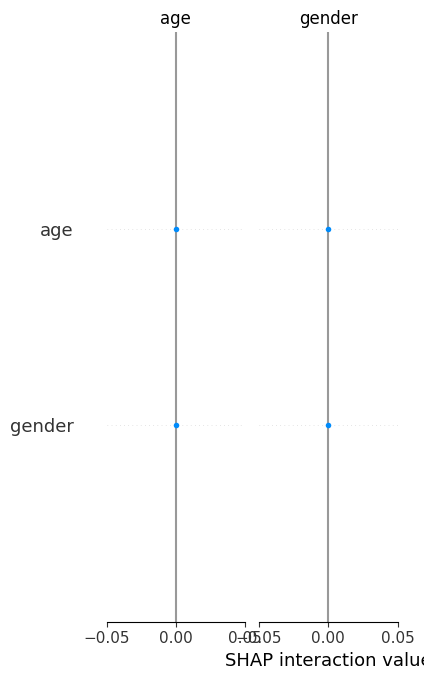

In [57]:
import shap

# 1. Background (random 100 samples from metadata)
background = metadata[torch.randperm(len(metadata))[:100]].to(device)

# 2. Explanation set (first 10 samples for inspection)
metadata_sample = metadata[:10].to(device)

# 3. DeepExplainer for metadata-only model
explainer = shap.DeepExplainer(meta_model, background)

# 4. SHAP values
shap_values = explainer.shap_values(metadata_sample)

# 5. Plot summary
shap.summary_plot(
    shap_values,
    features=metadata_sample.cpu().numpy(),
    feature_names=['age', 'gender']
)


In [38]:
with torch.no_grad():
    outputs = meta_model(metadata_sample)
    print(outputs)


tensor([[0.2939, 0.7061]])
